## $\text{Selection of Algorithm}$:
### $\text{We will use Robust-Random-Cut-Forest Algorithm to detect anomalies }$



### $\text{Overview of Random Cut Forest (RCF):}$
**Type:** Unsupervised anomaly detection algorithm.

**Purpose:** Identifies anomalous data points that deviate from normal patterns.

**Key Features**
**Unsupervised Learning:** No labeled data required.

**Anomaly Detection:** Detects unexpected spikes, breaks in periodicity, and unclassifiable points.

**How It Works: **

**Random Cuts:** Constructs trees by making random splits in the data.

**Scoring:** Assigns anomaly scores based on isolation—more isolated points get higher scores.

**Aggregation:** Combines scores from multiple trees for a final anomaly score.



Anomaly Detected at Index: 51
Anomaly Detected at Index: 52
Anomaly Detected at Index: 53
Anomaly Detected at Index: 54
Anomaly Detected at Index: 55
Anomaly Detected at Index: 56
Anomaly Detected at Index: 57
Anomaly Detected at Index: 58
Anomaly Detected at Index: 59
Anomaly Detected at Index: 60
Anomaly Detected at Index: 61
Anomaly Detected at Index: 62
Anomaly Detected at Index: 63
Anomaly Detected at Index: 64
Anomaly Detected at Index: 65
Anomaly Detected at Index: 66
Anomaly Detected at Index: 67
Anomaly Detected at Index: 68
Anomaly Detected at Index: 70
Anomaly Detected at Index: 71
Anomaly Detected at Index: 73
Anomaly Detected at Index: 74
Anomaly Detected at Index: 75
Anomaly Detected at Index: 81
Anomaly Detected at Index: 129
Anomaly Detected at Index: 148
Anomaly Detected at Index: 149
Anomaly Detected at Index: 150
Anomaly Detected at Index: 151
Anomaly Detected at Index: 199
Anomaly Detected at Index: 201
Anomaly Detected at Index: 204
Anomaly Detected at Index: 205
A

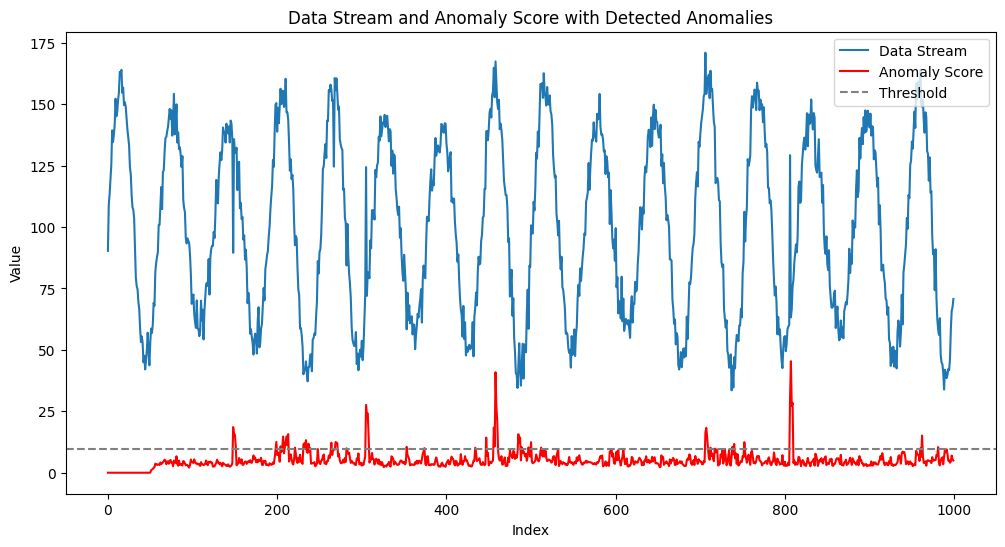

In [24]:
import numpy as np
import rrcf
import matplotlib.pyplot as plt

# Function to generate a data stream with patterns, seasonality, and noise
def generate_data_stream(pattern_length):
    try:
        if not isinstance(pattern_length, int) or pattern_length <= 0:
            raise ValueError("Pattern length must be a positive integer.")

        n = pattern_length
        A = 50  # Amplitude
        center = 100  # Center value
        T = 50  # Period for regular patterns
        seasonal_effect = 10 * np.sin(2 * np.pi * np.arange(n) / T)  # Seasonal component
        noise = np.random.normal(0, 5, n)  # Random noise
        time = np.arange(n)

        # Create a data stream with regular patterns, seasonal effects, and noise
        data_stream = A * np.sin(0.1 * time) + seasonal_effect + noise + center
        return data_stream

    except ValueError as e:
        print(f"Error in generate_data_stream: {e}")

# Function to add anomalies to the data stream
def add_anomalies_to_data(data_stream):
    try:
        if not isinstance(data_stream, (list, np.ndarray)):
            raise TypeError("Data stream must be a list or NumPy array.")

        anomaly_indices = np.random.choice(len(data_stream), 5, replace=False)  # Randomly choose indices for anomalies
        anomaly_values = np.random.uniform(low=70, high=130, size=5)  # Random anomaly values

        for index, value in zip(anomaly_indices, anomaly_values):
            data_stream[index] = value

    except TypeError as e:
        print(f"Error in add_anomalies_to_data: {e}")

# Class to implement Random Cut Tree (RCT) Forest for anomaly detection
class RCTreeForest:
    def __init__(self, num_trees, tree_size, window_size):
        try:
            if not all(isinstance(param, int) and param > 0 for param in [num_trees, tree_size, window_size]):
                raise ValueError("All parameters must be positive integers.")

            self.num_trees = num_trees
            self.tree_size = tree_size
            self.shingle_size = window_size
            self.forest = [rrcf.RCTree() for _ in range(num_trees)]

        except ValueError as e:
            print(f"Error in initialization: {e}")

    def anomaly_detector(self, index, point):
        try:
            if not isinstance(index, int) or index < 0:
                raise ValueError("Index must be a non-negative integer.")

            if not isinstance(point, list) or len(point) != self.shingle_size or not all(isinstance(p, (int, float)) for p in point):
                raise ValueError(f"Point must be a list of {self.shingle_size} numeric values.")

            avg_codisplacement = 0

            for tree in self.forest:
                if len(tree.leaves) > self.tree_size:
                    tree.forget_point(index - self.tree_size)

                tree.insert_point(point, index=index)
                new_codisplacement = tree.codisp(index)
                avg_codisplacement += new_codisplacement / self.num_trees

            return avg_codisplacement

        except ValueError as e:
            print(f"Error in anomaly detection: {e}")
            return 0

# Main script
if __name__ == "__main__":
    # Generate a data stream with patterns, seasonality, and noise
    data_stream = generate_data_stream(1000)

    # Introduce anomalies to the generated data stream
    add_anomalies_to_data(data_stream)

    # RCT parameters
    num_trees = 40
    tree_size = 256
    shingle_size = 4

    # Create an instance of the RCTreeForest class
    forest = RCTreeForest(num_trees, tree_size, shingle_size)

    # Initialize lists for anomaly scores and the current data window
    anomaly_score = []
    current_window = []

    # Warm-up period to avoid false anomalies
    warmup_period = 50

    # Loop through the data stream to detect anomalies
    for i in range(len(data_stream)):
        if i < forest.shingle_size:
            current_window.append(data_stream[i])
            anomaly_score.append(0)
            continue
        else:
            current_window.append(data_stream[i])
            current_window = current_window[1:]

        # Apply the warm-up period
        if i >= warmup_period:
            score = forest.anomaly_detector(i, current_window)
            anomaly_score.append(score)

            # Detect anomalies based on thresholding
            window_scores = np.array(anomaly_score[max(0, i - 50):i])
            if len(window_scores) > 0:
                threshold = np.median(window_scores) + 2 * np.std(window_scores)  # Use median and std for threshold
                if score > threshold:
                    print(f"Anomaly Detected at Index: {i}")

        else:
            anomaly_score.append(0)

    # Plot the data stream and anomaly scores
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(data_stream)), data_stream, label='Data Stream')
    plt.plot(np.arange(len(anomaly_score)), anomaly_score, label='Anomaly Score', color='red')
    plt.title('Data Stream and Anomaly Score with Detected Anomalies')
    plt.axhline(y=threshold, color='gray', linestyle='--', label='Threshold')
    plt.legend(loc='upper right')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()


# Anomaly Detection Using Random Cut Tree (RCT) Forest

## 1. Concise Explanation of the Algorithm:

### Algorithm Used: Random Cut Tree (RCT) Forest for Anomaly Detection

**Description:**
The RCT forest is a collection of random cut trees that effectively identify anomalies in data streams. Each tree is built by making random cuts in the feature space, enabling the algorithm to model the underlying distribution of the data. The co-displacement measure of a point indicates how much it deviates from normal patterns; higher values signify potential anomalies.

**Effectiveness:**
This method is particularly suited for streaming data because it allows for real-time updates and fast anomaly detection without requiring the entire dataset to be stored in memory. It is robust against noise and can adapt to changes in data patterns over time.

---

## 2. Robust Error Handling:

The code includes error handling in key functions:

- **`generate_data_stream`:** Raises a `ValueError` if the `pattern_length` is not a positive integer.
  
- **`add_anomalies_to_data`:** Raises a `TypeError` if the input data stream is not a list or NumPy array.
  
- **`RCTreeForest` class:** Validates that parameters (`num_trees`, `tree_size`, `window_size`) are positive integers during initialization and checks the validity of input to the `anomaly_detector` method.

---

## 3. Data Validation:

Data validation is implemented in several parts:

- **Input Type Checks:** Each function checks if the inputs are of the expected type (e.g., integers, lists, or NumPy arrays) and have the required properties (e.g., positive integers).
  
- **Anomaly Injection:** Anomalies are added in a controlled manner using random indices and values, ensuring they remain within the bounds of the data stream.
